In [1]:
import tensorflow as tf
import functools
import numpy as np
import pandas as pd

In [2]:
TRAIN_DATA_URL = "https://storage.googleapis.com/tf-datasets/titanic/train.csv"
TEST_DATA_URL = "https://storage.googleapis.com/tf-datasets/titanic/eval.csv"

In [3]:
# It will download the dataset form the given url and return us the local file path
# we can directly assign it a path if it is already present
train_file_path = tf.keras.utils.get_file(fname="train.csv", origin=TRAIN_DATA_URL)
test_file_path = tf.keras.utils.get_file(fname="test.csv", origin=TEST_DATA_URL)
print(train_file_path, test_file_path)

C:\Users\AAIC\.keras\datasets\train.csv C:\Users\AAIC\.keras\datasets\test.csv


In [4]:
# make numpy values easy to read
np.set_printoptions(precision=3, suppress=True)

### load the data with tf.data 

- define the label column and the list of possible values in csv for that label column

In [5]:
LABEL_COLUMN = 'survived'
LABELS = [0, 1]

- We will generate the dataset from csv using make_csv_dataset
    - `file_patterns`: can be list of file_paths or pattern of those filepaths.
    - `label_name`: specifies the column (Y) in the csv.
    - `na_value`: value in csv that is represented as csv file
    - `num_epochs`: The number of times the dataset is repeated while iterating
        through dataset
    - `ignore_errors`: to ignore any errors while parsing the data.
    
   
- Returns: of type `PrefetchDataset`

In [6]:
def get_dataset(file_path, **kwargs):
    return tf.data.experimental.make_csv_dataset(
        file_pattern=file_path,
        batch_size=4,
        label_name=LABEL_COLUMN,
        na_value='?',
        num_epochs=1,
        ignore_errors=True,
        **kwargs
    )

In [7]:
raw_train_data = get_dataset(train_file_path)
raw_test_data = get_dataset(test_file_path, shuffle=False)

type(raw_train_data), type(raw_test_data)

Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_determinstic`.


(tensorflow.python.data.ops.dataset_ops.PrefetchDataset,
 tensorflow.python.data.ops.dataset_ops.PrefetchDataset)

- these two datasets, will return batch in OrderedDict format. Where, key is the `columnname(feature)` and it's value is a list of values of respective column of size `batchsize`, which is _4_ as we've specified while making the dataset in the above function
- `take` is like taking how many points we want to iterate through. It is better than writing a break after first loop

In [8]:
def show_batch(dataset):
    for batch, labels in dataset.take(1):
        print("{:20s}: {}\n".format('labels', labels.numpy()))
        for feature, values in batch.items():
            print("{:20s}: {}".format(feature, values.numpy()))

In [9]:
show_batch(raw_train_data)

labels              : [0 0 0 0]

sex                 : [b'male' b'male' b'male' b'female']
age                 : [51. 26. 23. 18.]
n_siblings_spouses  : [0 0 0 1]
parch               : [0 0 0 0]
fare                : [12.525  7.775 13.    17.8  ]
class               : [b'Second' b'Third' b'Second' b'Third']
deck                : [b'unknown' b'unknown' b'unknown' b'unknown']
embark_town         : [b'Southampton' b'Southampton' b'Southampton' b'Southampton']
alone               : [b'y' b'y' b'y' b'n']


# Data preprocessing

- As our dataset has both numeric and categorical columns. We will write a pipeline which does the preprocessing of numerical columns (like normalization) and categorical columns (like one hot encoding) as part of the keras model. 
- This helps when shipping the model. ie., we can give raw data point without any pre processing and can predict the label.


- We will do this in two stages. First, we will combine all the numerical columns into one column `numeric`. It will be a matrix of stacked features and we will normalize them with `train_mean` and `train_std` of those numerical features 
- Next, we will deal with categorical features one by one

## Numeric Features

In [10]:
NUMERIC_FEATURES = ['age','n_siblings_spouses','parch', 'fare']

- First, we will write a class to pack numerical features

In [11]:
class PackNumericFeatures(object):
    """Given an batch(orderedDict) and list of numeric columns, stack them up"""
    def __init__(self, names):
        # names of the numeric columns
        self.names = names
    
    def __call__(self, features, labels):
        """this function can be called with classname with features and labels. 
        Can be useful while calling for a batch while training"""
        
        # get the list of list of values for each feature one by one.
        # After this features (orderedDict) left with categorical features
        # and `numeric` key that has stacked features of all the numeric features
        numeric_features = [features.pop(name) for name in self.names]
        
        # convert each numeric calumn to float32.
        numeric_features = [tf.cast(feat, tf.float32) for feat in numeric_features]
        
        # stack them (list of arrays) column wise
        numeric_features = tf.stack(values=numeric_features, axis=-1)
        
        # add this `numeric` to the features orderdDict
        features['numeric'] = numeric_features
        
        return features, labels

- This can be explained using a sample dataset that has only numeric columns

In [12]:
SELECT_COLUMNS = ['survived', 'age', 'n_siblings_spouses', 'parch', 'fare']
DEFAULTS = [0, 0.0, 0.0, 0.0, 0.0]

In [13]:
temp_dataset = get_dataset(train_file_path,
                           select_columns=SELECT_COLUMNS,  # select only few columns
                           column_defaults = DEFAULTS)

show_batch(temp_dataset)

labels              : [0 0 1 1]

age                 : [22. 35. 24. 50.]
n_siblings_spouses  : [0. 0. 0. 2.]
parch               : [0. 0. 3. 0.]
fare                : [  7.796  10.5    19.258 133.65 ]


In [14]:
example_batch, labels_batch = next(iter(temp_dataset))

In [15]:
list(example_batch.keys()), labels_batch.numpy()

(['age', 'n_siblings_spouses', 'parch', 'fare'], array([0, 1, 0, 0]))

In [16]:
for feat, values in example_batch.items():
    print("{:20s}: {}".format(feat, values.numpy()))

age                 : [28. 40. 28. 32.]
n_siblings_spouses  : [0. 1. 8. 0.]
parch               : [0. 1. 2. 0.]
fare                : [  7.896 134.5    69.55   10.5  ]


In [17]:
example_batch, labels_batch = PackNumericFeatures(NUMERIC_FEATURES)(example_batch, labels_batch)

In [18]:
example_batch.keys(), labels_batch.numpy()

(odict_keys(['numeric']), array([0, 1, 0, 0]))

In [19]:
example_batch['numeric'].numpy()

array([[ 28.   ,   0.   ,   0.   ,   7.896],
       [ 40.   ,   1.   ,   1.   , 134.5  ],
       [ 28.   ,   8.   ,   2.   ,  69.55 ],
       [ 32.   ,   0.   ,   0.   ,  10.5  ]], dtype=float32)

- we can clearly see that the class is working as expected. And you can verify with the above batch of datapoints

- Now we can apply this to whole train and test data using map. 
- `map` allows us to call the packednumericfeatures function for all the batches

In [20]:
# columns before calling the dataset
tmp_batch, tmp_labels = next(iter(raw_train_data))
print(list(tmp_batch.keys()), tmp_labels.numpy())

['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck', 'embark_town', 'alone'] [1 0 0 1]


In [21]:
packed_train_data = raw_train_data.map(PackNumericFeatures(NUMERIC_FEATURES))
packed_test_data = raw_test_data.map(PackNumericFeatures(NUMERIC_FEATURES))

- we can check the columns after it is done

In [22]:
tmp_packed_batch, tmp_packed_labels = next(iter(packed_train_data))
print(list(tmp_packed_batch.keys()), tmp_packed_labels.numpy())

['sex', 'class', 'deck', 'embark_town', 'alone', 'numeric'] [0 1 1 0]


- Notice that extra `numeric` column without any other numeric columns

- This can be verified by looking at a batch of data points from the packed train data

In [23]:
show_batch(packed_test_data)

labels              : [0 0 1 1]

sex                 : [b'male' b'male' b'female' b'female']
class               : [b'Third' b'First' b'First' b'Second']
deck                : [b'unknown' b'E' b'C' b'unknown']
embark_town         : [b'Southampton' b'Southampton' b'Southampton' b'Southampton']
alone               : [b'y' b'y' b'y' b'y']
numeric             : [[35.     0.     0.     8.05 ]
 [54.     0.     0.    51.862]
 [58.     0.     0.    26.55 ]
 [55.     0.     0.    16.   ]]


- This packed_train_data and packed_test_data are the datasets that we will use for training

### Normalizing continuous varaiables

In [24]:
import pandas as pd
desc = pd.read_csv(train_file_path)[NUMERIC_FEATURES].describe()
desc

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [25]:
## get the mean and standard deviation of those numeric features
MEAN = desc.loc['mean'].values
STD = desc.loc['std'].values
MEAN, STD

(array([29.631,  0.545,  0.38 , 34.385]),
 array([12.512,  1.151,  0.793, 54.598]))

- We will achieve this using partial function which will be used as normalizer_function.
- This will receive the batch_data while training and it should return the normalized one.
- Note that we will use only train mean and standard deviation to normalize both while training and evaluation mode

In [26]:
# generic function to normalize the data
def normalize_numeric_data(data, mean, std):
  # Center the data
  return (data-mean)/std

In [27]:
normalizer = functools.partial(normalize_numeric_data, mean=MEAN, std=STD)
# we can call the normalizer with data as the only argument and 
# mean and std need not be passed

In [28]:
# notice that it is not asking for mean and std as they are already provided
normalizer()

TypeError: normalize_numeric_data() missing 1 required positional argument: 'data'

- Create a numeric_column which can be used in Keras model as a pre processing layer

In [29]:
numeric_column = tf.feature_column.numeric_column(
    key='numeric', shape=[len(NUMERIC_FEATURES)],
    dtype=tf.float32,normalizer_fn=normalizer
)

# storing thise numerical columns in a list.
numeric_columns = [numeric_column]
numeric_columns

[NumericColumn(key='numeric', shape=(4,), default_value=None, dtype=tf.float32, normalizer_fn=functools.partial(<function normalize_numeric_data at 0x0000022F25CF5158>, mean=array([29.631,  0.545,  0.38 , 34.385]), std=array([12.512,  1.151,  0.793, 54.598])))]

In [30]:
numeric_layer = tf.keras.layers.DenseFeatures(feature_columns=numeric_columns)
numeric_layer(tmp_packed_batch).numpy()

array([[ 0.269, -0.474, -0.479, -0.538],
       [ 0.189, -0.474, -0.479, -0.486],
       [ 0.509,  0.395,  2.043,  1.568],
       [ 0.429, -0.474, -0.479, -0.499]], dtype=float32)

- the above values are normalized values of `numeric` column over the dataset

## Categorical data

In [31]:
# these are just feature and vocabulary pairs.
# Used to construct the indicator columns very easily
CATEGORIES = {
    'sex': ['male', 'female'],
    'class' : ['First', 'Second', 'Third'],
    'deck' : ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'],
    'embark_town' : ['Cherbourg', 'Southhampton', 'Queenstown'],
    'alone' : ['y', 'n']
}

- we will create categorical_column with tensorflow feature_column

In [32]:
categorical_columns = []

for feature, vocab in CATEGORIES.items():
    cat_col = tf.feature_column.categorical_column_with_vocabulary_list(key=feature,
                                                                       vocabulary_list=vocab)
    print(cat_col)
    print('-'*30)
    categorical_columns.append(tf.feature_column.indicator_column(cat_col))


VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0)
------------------------------
VocabularyListCategoricalColumn(key='class', vocabulary_list=('First', 'Second', 'Third'), dtype=tf.string, default_value=-1, num_oov_buckets=0)
------------------------------
VocabularyListCategoricalColumn(key='deck', vocabulary_list=('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'), dtype=tf.string, default_value=-1, num_oov_buckets=0)
------------------------------
VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Cherbourg', 'Southhampton', 'Queenstown'), dtype=tf.string, default_value=-1, num_oov_buckets=0)
------------------------------
VocabularyListCategoricalColumn(key='alone', vocabulary_list=('y', 'n'), dtype=tf.string, default_value=-1, num_oov_buckets=0)
------------------------------


In [33]:
# categorical layer(s) with keras.layers
categorical_layer = tf.keras.layers.DenseFeatures(categorical_columns)
print(categorical_layer(tmp_packed_batch).numpy())

Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
[[1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


- note that, we won't be using this saperately. We will combine all the numerical columns and categorical columns(indicator column) as a single pre processing layer

In [34]:
preprocessing_layer = tf.keras.layers.DenseFeatures(categorical_columns+numeric_columns)

### Build a model that includes all the pre processing steps

In [40]:
class NWPPLayer(tf.keras.Model):
    def __init__(self):
        super(NWPPLayer, self).__init__()
        # preprocessing layer
        self.preprocessinglayer = tf.keras.layers.DenseFeatures(categorical_columns+numeric_columns)
        self.layer1 = tf.keras.layers.Dense(units=128, activation='relu')
        self.layer2 = tf.keras.layers.Dense(units=128, activation='relu')
        self.outputlayer = tf.keras.layers.Dense(units=1, activation='sigmoid')
    
    @tf.function
    def call(self, x, training=False, **kwargs):
        """`x` is a ordered dictionary for each batch of input data"""
        x = self.preprocessinglayer(x)
        # print(x.shape)  # (batch_size, 24) --> 24 including one-hot encoded vectors 
        x=self.layer2(self.layer1(x))
        return self.outputlayer(x)
    
    def evaluate(self, data, loss_fn):
        out, labels = [], []
        for batch, batch_labels in data:
            out.append(self.call(batch))
            labels.append(batch_labels)

        y_pred, y_true = tf.concat(out, 0), tf.concat(labels, 0)
        acc = tf.metrics.BinaryAccuracy()(y_true=y_true, y_pred=y_pred).numpy()
        loss = loss_fn(y_true=y_true, y_pred=y_pred).numpy()
        return acc*100, loss
    
    @tf.function
    def train_step(self, data, labels, loss_fn):
        # record all the computations with gradient tape
        with tf.GradientTape() as tape:
            # forward pass
            outputs = self.call(data)
            loss = loss_fn(y_true=labels, y_pred=outputs)

        # backward pass
        # find the gradients w.r.t loss
        gradients = tape.gradient(loss, model.trainable_variables)
        # grads_and_vars: List of (gradient, variable) pairs.
        optimizer.apply_gradients(grads_and_vars=zip(gradients, model.trainable_variables))

        return loss

In [41]:
import math

In [42]:
def get_data_size_and_batch_size(data):
    """
    Gives you the datasize and batch_size for the dataset
    """
    size, batch_size = 0, 0
    
    batch, labels = next(iter(data))
    batch_size = labels.shape[0]
    
    for batch, labels in data:
        size+=labels.shape[0]
        
    return size, batch_size

get_data_size_and_batch_size(packed_train_data)

(627, 4)

In [43]:
def train(model, optimizer, loss_fn, train_data, validation_data, epochs=1, validate_epoch=3):
    """
    Train the model with the parameters given and returns the history
    """
    train_params = {'loss':[], 'accuracy': [], 'epoch':[]}
    val_params = {'loss':[], 'accuracy': [], 'epoch':[]}
    loss_arr = []  # this is for every iteration
    
    # getting size and batch_size of train
    train_size, train_batch_size = get_data_size_and_batch_size(train_data)
    iters = math.ceil(train_size/train_batch_size)
    
    for epoch in range(1, epochs+1):
        print()
        for i, data in enumerate(train_data):
            batch, labels = data            
            loss = model.train_step(batch, labels, loss_fn)
            
            # save the loss for this batch
            loss_arr.append(loss.numpy())
            print(f'Epoch: {epoch}\t iter:{i+1}/{iters}\t loss:{loss_arr[-1]}', end='\r')
        
        if epoch%validate_epoch == 0:
            print('\nEvaluating the model for train and validation data...', end='\r')
            # calculate the train and validation accuracy and loss
            train_acc, train_loss = model.evaluate(train_data, loss_fn)
            train_params['loss'].append(train_loss)
            train_params['accuracy'].append(train_acc)
            train_params['epoch'].append(epoch+1)

            val_acc, val_loss = model.evaluate(validation_data, loss_fn)
            val_params['loss'].append(val_loss)
            val_params['accuracy'].append(val_acc)
            val_params['epoch'].append(epoch+1)

            template = 'Epoch: {} - Train (Loss: {}, acc: {}) - Val (Loss: {}, acc: {})'
            print(template.format(epoch,
                                  train_loss, train_acc,
                                  val_loss, val_acc),
                  end='\n')
    
    # return after the training is over
    print()
    return train_params, val_params, loss_arr

In [44]:
%%time
model = NWPPLayer()
loss_fn = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam()  # training on defaults

train_params, val_params, loss_arr = train(model=model,optimizer=optimizer, loss_fn=loss_fn, epochs=10,
                                           train_data=packed_train_data, validation_data=packed_test_data)


Epoch: 1	 iter:157/157	 loss:0.22614066302776337
Epoch: 2	 iter:157/157	 loss:0.34167322516441345
Epoch: 3	 iter:157/157	 loss:0.60039275884628336
Epoch: 3 - Train (Loss: 0.36536455154418945, acc: 84.84848737716675) - Val (Loss: 0.43980979919433594, acc: 81.0606062412262)

Epoch: 4	 iter:157/157	 loss:0.14283613860607147
Epoch: 5	 iter:157/157	 loss:0.54652947187423713
Epoch: 6	 iter:157/157	 loss:0.20585899055004127
Epoch: 6 - Train (Loss: 0.3488459885120392, acc: 85.16746163368225) - Val (Loss: 0.4152870178222656, acc: 82.95454382896423)

Epoch: 7	 iter:157/157	 loss:0.48850286006927493
Epoch: 8	 iter:157/157	 loss:0.360177636146545475
Epoch: 9	 iter:157/157	 loss:0.067801572382450155
Epoch: 9 - Train (Loss: 0.3325525224208832, acc: 85.16746163368225) - Val (Loss: 0.46765008568763733, acc: 80.68181872367859)

Epoch: 10	 iter:157/157	 loss:0.052081014961004264
Wall time: 13.4 s


In [45]:
import matplotlib.pyplot as plt

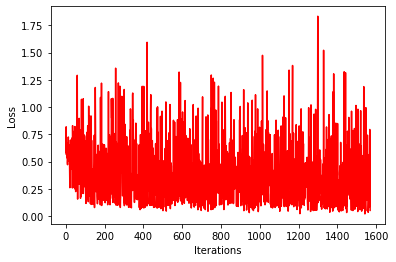

In [46]:
plt.plot(loss_arr, 'r')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

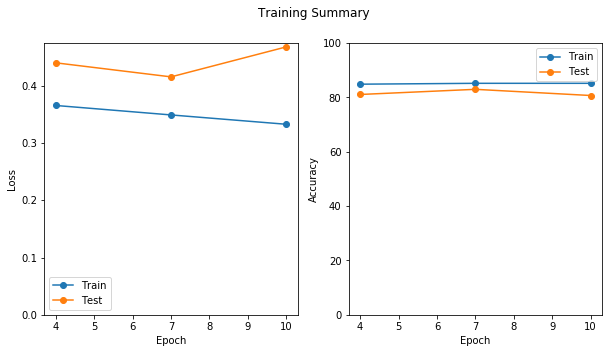

In [49]:
plt.subplots(1,2, sharex=True, figsize=(10, 5))
plt.suptitle('Training Summary')

plt.subplot(1,2,1)
plt.plot(train_params['epoch'], train_params['loss'], marker='o', label='Train')
plt.plot(val_params['epoch'], val_params['loss'], marker='o', label='Test')
plt.xlabel('Epoch')
plt.ylim(bottom=0)
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_params['epoch'], train_params['accuracy'], marker='o', label='Train')
plt.plot(val_params['epoch'], val_params['accuracy'], marker='o', label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0,100)
plt.legend()
plt.show()

## Training with keras sequential APIs

In [50]:
model1 = tf.keras.Sequential(layers=[
    preprocessing_layer,
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

model1.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy']
)

In [51]:
train_data = packed_train_data.shuffle(buffer_size=500)
test_data = packed_test_data

In [52]:
%%time
history = model1.fit(x=train_data, epochs=10)

Epoch 1/10
157/157 [==============================] - 4s 24ms/step - loss: 0.5081 - accuracy: 0.7863
Epoch 2/10
157/157 [==============================] - 1s 6ms/step - loss: 0.4217 - accuracy: 0.8262
Epoch 3/10
157/157 [==============================] - 1s 6ms/step - loss: 0.4003 - accuracy: 0.8262
Epoch 4/10
157/157 [==============================] - 1s 6ms/step - loss: 0.3850 - accuracy: 0.8325
Epoch 5/10
157/157 [==============================] - 1s 6ms/step - loss: 0.3816 - accuracy: 0.8421
Epoch 6/10
157/157 [==============================] - 1s 7ms/step - loss: 0.3651 - accuracy: 0.8469
Epoch 7/10
157/157 [==============================] - 1s 6ms/step - loss: 0.3652 - accuracy: 0.8453
Epoch 8/10
157/157 [==============================] - 1s 6ms/step - loss: 0.3595 - accuracy: 0.8549
Epoch 9/10
157/157 [==============================] - 1s 6ms/step - loss: 0.3537 - accuracy: 0.8437
Epoch 10/10
157/157 [==============================] - 1s 6ms/step - loss: 0.3459 - accuracy: 0.854

In [53]:
history.history

{'loss': [0.5076252789588637,
  0.4204417937680295,
  0.4015993078787361,
  0.3871122618136033,
  0.38088044902069146,
  0.36581794884311336,
  0.36281968776784257,
  0.35785050188715567,
  0.3524662312090492,
  0.34565482453771373],
 'accuracy': [0.7862839,
  0.8261563,
  0.8261563,
  0.83253586,
  0.84210527,
  0.84689,
  0.8452951,
  0.8548644,
  0.8437002,
  0.8548644]}

In [54]:
%%timeit
test_loss, test_accuracy = model1.evaluate(test_data)
print('\n\nTest Loss {}, Test Accuracy {}'.format(test_loss, test_accuracy))

66/66 [==============================] - 1s 10ms/step - loss: 0.4585 - accuracy: 0.8068


Test Loss 0.4584726510625897, Test Accuracy 0.8068181872367859
66/66 [==============================] - 0s 7ms/step - loss: 0.4585 - accuracy: 0.8068


Test Loss 0.4584726510625897, Test Accuracy 0.8068181872367859
66/66 [==============================] - 0s 7ms/step - loss: 0.4585 - accuracy: 0.8068


Test Loss 0.4584726510625897, Test Accuracy 0.8068181872367859
66/66 [==============================] - 0s 7ms/step - loss: 0.4585 - accuracy: 0.8068


Test Loss 0.4584726510625897, Test Accuracy 0.8068181872367859
66/66 [==============================] - 0s 7ms/step - loss: 0.4585 - accuracy: 0.8068.4725 -


Test Loss 0.4584726510625897, Test Accuracy 0.8068181872367859
66/66 [==============================] - 0s 7ms/step - loss: 0.4585 - accuracy: 0.8068


Test Loss 0.4584726510625897, Test Accuracy 0.8068181872367859
66/66 [==============================] - 1s 8ms/step - loss: 0.4585 - accuracy: 

In [55]:
%%timeit
test_loss, test_accuracy = model.evaluate(test_data, loss_fn)
print('\n\nTest Acc {}, Test loss {}'.format(test_loss, test_accuracy))



Test Acc 82.95454382896423, Test loss 0.43067270517349243


Test Acc 82.95454382896423, Test loss 0.43067270517349243


Test Acc 82.95454382896423, Test loss 0.43067270517349243


Test Acc 82.95454382896423, Test loss 0.43067270517349243


Test Acc 82.95454382896423, Test loss 0.43067270517349243


Test Acc 82.95454382896423, Test loss 0.43067270517349243


Test Acc 82.95454382896423, Test loss 0.43067270517349243


Test Acc 82.95454382896423, Test loss 0.43067270517349243
213 ms ± 28 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### ------------ almost twice as fast as keras evaluate

In [56]:
%time
predictions = model1.predict(test_data)

# Show some results
for prediction, survived in zip(predictions[:20], list(test_data)[0][1][:20]):
    print("Predicted survival: {:.2%}".format(prediction[0]),
        " | Actual outcome: ",
        ("SURVIVED" if bool(survived) else "DIED"))


Wall time: 0 ns
Predicted survival: 20.47%  | Actual outcome:  DIED
Predicted survival: 55.71%  | Actual outcome:  DIED
Predicted survival: 87.67%  | Actual outcome:  SURVIVED
Predicted survival: 84.86%  | Actual outcome:  SURVIVED


## Save the trained model along with the optimizer